In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical
import keras
from keras import layers
from keras.layers import *
from keras.models import Model, Sequential
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import h5py
from matplotlib import pyplot as plt
from PIL import Image
from scipy.io import loadmat

Using TensorFlow backend.


In [2]:
data = loadmat('jaffe_mean_data.mat')['jaffe_mean_data']

In [3]:
data = data.reshape((181,256,256,1))

In [4]:
label = loadmat('cl_label.mat')['cl_label']

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size=0.2,random_state=0)

In [6]:
print('Training: ',X_train.shape)

Training:  (144, 256, 256, 1)


In [7]:
from keras.layers import Convolution2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten, AveragePooling2D

In [8]:
from keras.models import Sequential

In [9]:
def get_nn_model():
    model = Sequential()
    model.add(MaxPooling2D(pool_size = (4,4), strides=None,input_shape=(256,256,1)))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(Dropout(0.5))

    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    return model

In [10]:
def get_cnn_model():
    model = Sequential()
    model.add(Convolution2D(64, (3, 3), padding='same',input_shape=(256,256,1)))
    model.add(Convolution2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(128, (3, 3), padding='same'))
    model.add(Convolution2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(256, (3, 3), padding='same'))
    model.add(Convolution2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(512, (3, 3), padding='same'))
    model.add(Convolution2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(7))
    model.add(Activation('softmax'))
    return model

In [11]:
cnn_model = get_cnn_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
nn_model = get_nn_model()

In [13]:
from keras.preprocessing.image import ImageDataGenerator 

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [15]:
from keras import backend as K

In [16]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 1

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))

In [25]:
def train_cnn_model(model):
    filepath='../opt/jaffe-cnn/Model.{epoch:02d}-{val_acc:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', cooldown=0, min_lr=0)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,   # randomly flip images
        )


    datagen.fit(X_train)
    datagen.fit(X_test)    
    batch_size = 32

    num_epochs = 100
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=[fbeta, 'acc'])
    train_flow = datagen.flow(X_train, Y_train, batch_size=batch_size)
    validation_flow = datagen.flow(X_test, Y_test)
    history = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=validation_flow, 
                    validation_steps=len(X_test) / batch_size,
                    callbacks=[checkpointer, reduce_lr, checkpointer])
    return history, model

In [26]:
def train_nn_model(model):
    filepath='../opt/jaffe-nn/Model.{epoch:02d}-{val_acc:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', cooldown=0, min_lr=0)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,   # randomly flip images
        )


    datagen.fit(X_train)
    datagen.fit(X_test)    
    batch_size = 32

    num_epochs = 100
    model.compile(loss='categorical_crossentropy',
             optimizer='sgd',
             metrics=[fbeta, 'acc'])
    train_flow = datagen.flow(X_train, Y_train, batch_size=batch_size)
    validation_flow = datagen.flow(X_test, Y_test)
    history = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=validation_flow, 
                    validation_steps=len(X_test) / batch_size,
                    callbacks=[checkpointer, reduce_lr, checkpointer])
    return history, model

In [27]:
 cnn_history, cnn_model = train_cnn_model(cnn_model)

Epoch 1/100
5/4 [=================================] - 7s 1s/step - loss: 1.0287 - fbeta: 0.6800 - acc: 0.6927 - val_loss: 13.6428 - val_fbeta: 0.1351 - val_acc: 0.1351

Epoch 00001: saving model to ../opt/jaffe-cnn/Model.01-0.1351.hdf5

Epoch 00001: saving model to ../opt/jaffe-cnn/Model.01-0.1351.hdf5
Epoch 2/100
5/4 [=================================] - 2s 334ms/step - loss: 1.0522 - fbeta: 0.5521 - acc: 0.6146 - val_loss: 13.9400 - val_fbeta: 0.1351 - val_acc: 0.1351

Epoch 00002: saving model to ../opt/jaffe-cnn/Model.02-0.1351.hdf5

Epoch 00002: saving model to ../opt/jaffe-cnn/Model.02-0.1351.hdf5
Epoch 3/100
5/4 [=================================] - 2s 334ms/step - loss: 0.9594 - fbeta: 0.6082 - acc: 0.6568 - val_loss: 13.9400 - val_fbeta: 0.1351 - val_acc: 0.1351

Epoch 00003: saving model to ../opt/jaffe-cnn/Model.03-0.1351.hdf5

Epoch 00003: saving model to ../opt/jaffe-cnn/Model.03-0.1351.hdf5
Epoch 4/100
5/4 [=================================] - 2s 333ms/step - loss: 0.7282


Epoch 00027: saving model to ../opt/jaffe-cnn/Model.27-0.3784.hdf5
Epoch 28/100
5/4 [=================================] - 2s 336ms/step - loss: 0.0648 - fbeta: 0.9873 - acc: 0.9873 - val_loss: 5.1637 - val_fbeta: 0.3243 - val_acc: 0.3243

Epoch 00028: saving model to ../opt/jaffe-cnn/Model.28-0.3243.hdf5

Epoch 00028: saving model to ../opt/jaffe-cnn/Model.28-0.3243.hdf5
Epoch 29/100
5/4 [=================================] - 2s 338ms/step - loss: 0.0990 - fbeta: 0.9578 - acc: 0.9578 - val_loss: 4.4253 - val_fbeta: 0.4324 - val_acc: 0.4324

Epoch 00029: saving model to ../opt/jaffe-cnn/Model.29-0.4324.hdf5

Epoch 00029: saving model to ../opt/jaffe-cnn/Model.29-0.4324.hdf5
Epoch 30/100
5/4 [=================================] - 2s 334ms/step - loss: 0.1256 - fbeta: 0.9578 - acc: 0.9578 - val_loss: 3.5218 - val_fbeta: 0.4324 - val_acc: 0.4324

Epoch 00030: saving model to ../opt/jaffe-cnn/Model.30-0.4324.hdf5

Epoch 00030: saving model to ../opt/jaffe-cnn/Model.30-0.4324.hdf5
Epoch 31/10


Epoch 00054: saving model to ../opt/jaffe-cnn/Model.54-0.9730.hdf5

Epoch 00054: saving model to ../opt/jaffe-cnn/Model.54-0.9730.hdf5
Epoch 55/100
5/4 [=================================] - 2s 336ms/step - loss: 0.0514 - fbeta: 0.9873 - acc: 0.9873 - val_loss: 0.3250 - val_fbeta: 0.9730 - val_acc: 0.9730

Epoch 00055: saving model to ../opt/jaffe-cnn/Model.55-0.9730.hdf5

Epoch 00055: saving model to ../opt/jaffe-cnn/Model.55-0.9730.hdf5
Epoch 56/100
5/4 [=================================] - 2s 337ms/step - loss: 0.0553 - fbeta: 0.9884 - acc: 0.9884 - val_loss: 0.3613 - val_fbeta: 0.9459 - val_acc: 0.9459

Epoch 00056: saving model to ../opt/jaffe-cnn/Model.56-0.9459.hdf5

Epoch 00056: saving model to ../opt/jaffe-cnn/Model.56-0.9459.hdf5
Epoch 57/100
5/4 [=================================] - 2s 334ms/step - loss: 0.0302 - fbeta: 0.9873 - acc: 0.9936 - val_loss: 0.4308 - val_fbeta: 0.9189 - val_acc: 0.9189

Epoch 00057: saving model to ../opt/jaffe-cnn/Model.57-0.9189.hdf5

Epoch 0005

5/4 [=================================] - 3s 668ms/step - loss: 0.0474 - fbeta: 0.9757 - acc: 0.9757 - val_loss: 0.2916 - val_fbeta: 0.9730 - val_acc: 0.9730

Epoch 00081: saving model to ../opt/jaffe-cnn/Model.81-0.9730.hdf5

Epoch 00081: saving model to ../opt/jaffe-cnn/Model.81-0.9730.hdf5
Epoch 82/100
5/4 [=================================] - 2s 334ms/step - loss: 0.0290 - fbeta: 0.9936 - acc: 0.9936 - val_loss: 0.2765 - val_fbeta: 0.9459 - val_acc: 0.9459

Epoch 00082: saving model to ../opt/jaffe-cnn/Model.82-0.9459.hdf5

Epoch 00082: saving model to ../opt/jaffe-cnn/Model.82-0.9459.hdf5
Epoch 83/100
5/4 [=================================] - 2s 334ms/step - loss: 0.0215 - fbeta: 0.9936 - acc: 1.0000 - val_loss: 0.2747 - val_fbeta: 0.9459 - val_acc: 0.9459

Epoch 00083: saving model to ../opt/jaffe-cnn/Model.83-0.9459.hdf5

Epoch 00083: saving model to ../opt/jaffe-cnn/Model.83-0.9459.hdf5
Epoch 84/100
5/4 [=================================] - 2s 337ms/step - loss: 0.0271 - fbeta:

In [28]:
nn_history, nn_model = train_nn_model(nn_model)

Epoch 1/100
5/4 [=================================] - 2s 448ms/step - loss: 0.9645 - fbeta: 0.4792 - acc: 0.6539 - val_loss: 1.3922 - val_fbeta: 0.2162 - val_acc: 0.5405

Epoch 00001: saving model to ../opt/jaffe-nn/Model.01-0.5405.hdf5

Epoch 00001: saving model to ../opt/jaffe-nn/Model.01-0.5405.hdf5
Epoch 2/100
5/4 [=================================] - 0s 10ms/step - loss: 0.8592 - fbeta: 0.5509 - acc: 0.7332 - val_loss: 1.5306 - val_fbeta: 0.2162 - val_acc: 0.4324

Epoch 00002: saving model to ../opt/jaffe-nn/Model.02-0.4324.hdf5

Epoch 00002: saving model to ../opt/jaffe-nn/Model.02-0.4324.hdf5
Epoch 3/100
5/4 [=================================] - 0s 12ms/step - loss: 0.9265 - fbeta: 0.5417 - acc: 0.6921 - val_loss: 1.2563 - val_fbeta: 0.2432 - val_acc: 0.5946

Epoch 00003: saving model to ../opt/jaffe-nn/Model.03-0.5946.hdf5

Epoch 00003: saving model to ../opt/jaffe-nn/Model.03-0.5946.hdf5
Epoch 4/100
5/4 [=================================] - 0s 11ms/step - loss: 0.8100 - fbeta:

Epoch 28/100
5/4 [=================================] - 0s 11ms/step - loss: 0.3295 - fbeta: 0.8738 - acc: 0.9120 - val_loss: 0.7065 - val_fbeta: 0.5676 - val_acc: 0.7838

Epoch 00028: saving model to ../opt/jaffe-nn/Model.28-0.7838.hdf5

Epoch 00028: saving model to ../opt/jaffe-nn/Model.28-0.7838.hdf5
Epoch 29/100
5/4 [=================================] - 0s 12ms/step - loss: 0.3830 - fbeta: 0.8380 - acc: 0.9080 - val_loss: 0.7203 - val_fbeta: 0.5676 - val_acc: 0.6757

Epoch 00029: saving model to ../opt/jaffe-nn/Model.29-0.6757.hdf5

Epoch 00029: saving model to ../opt/jaffe-nn/Model.29-0.6757.hdf5
Epoch 30/100
5/4 [=================================] - 0s 10ms/step - loss: 0.3490 - fbeta: 0.8380 - acc: 0.9184 - val_loss: 0.6577 - val_fbeta: 0.6486 - val_acc: 0.8649

Epoch 00030: saving model to ../opt/jaffe-nn/Model.30-0.8649.hdf5

Epoch 00030: saving model to ../opt/jaffe-nn/Model.30-0.8649.hdf5
Epoch 31/100
5/4 [=================================] - 0s 11ms/step - loss: 0.2750 - fbe

5/4 [=================================] - 0s 11ms/step - loss: 0.2512 - fbeta: 0.9080 - acc: 0.9334 - val_loss: 0.6204 - val_fbeta: 0.7568 - val_acc: 0.8649

Epoch 00055: saving model to ../opt/jaffe-nn/Model.55-0.8649.hdf5

Epoch 00055: saving model to ../opt/jaffe-nn/Model.55-0.8649.hdf5
Epoch 56/100
5/4 [=================================] - 0s 11ms/step - loss: 0.2029 - fbeta: 0.9439 - acc: 0.9693 - val_loss: 0.6501 - val_fbeta: 0.7568 - val_acc: 0.8108

Epoch 00056: saving model to ../opt/jaffe-nn/Model.56-0.8108.hdf5

Epoch 00056: saving model to ../opt/jaffe-nn/Model.56-0.8108.hdf5
Epoch 57/100
5/4 [=================================] - 0s 11ms/step - loss: 0.2482 - fbeta: 0.9057 - acc: 0.9375 - val_loss: 0.5761 - val_fbeta: 0.7297 - val_acc: 0.8378

Epoch 00057: saving model to ../opt/jaffe-nn/Model.57-0.8378.hdf5

Epoch 00057: saving model to ../opt/jaffe-nn/Model.57-0.8378.hdf5
Epoch 58/100
5/4 [=================================] - 0s 11ms/step - loss: 0.2042 - fbeta: 0.9566 - 

5/4 [=================================] - 0s 11ms/step - loss: 0.1644 - fbeta: 0.9578 - acc: 0.9821 - val_loss: 0.6014 - val_fbeta: 0.8108 - val_acc: 0.8378

Epoch 00082: saving model to ../opt/jaffe-nn/Model.82-0.8378.hdf5

Epoch 00082: saving model to ../opt/jaffe-nn/Model.82-0.8378.hdf5
Epoch 83/100
5/4 [=================================] - 0s 11ms/step - loss: 0.1736 - fbeta: 0.9514 - acc: 0.9821 - val_loss: 0.5385 - val_fbeta: 0.8108 - val_acc: 0.8649

Epoch 00083: saving model to ../opt/jaffe-nn/Model.83-0.8649.hdf5

Epoch 00083: saving model to ../opt/jaffe-nn/Model.83-0.8649.hdf5
Epoch 84/100
5/4 [=================================] - 0s 10ms/step - loss: 0.1600 - fbeta: 0.9745 - acc: 0.9873 - val_loss: 0.5423 - val_fbeta: 0.8108 - val_acc: 0.8919

Epoch 00084: saving model to ../opt/jaffe-nn/Model.84-0.8919.hdf5

Epoch 00084: saving model to ../opt/jaffe-nn/Model.84-0.8919.hdf5
Epoch 85/100
5/4 [=================================] - 0s 10ms/step - loss: 0.2538 - fbeta: 0.9068 - 

In [29]:
n_classes = label.shape[1]

In [30]:
labels=range(n_classes)

In [31]:
def eval_model(history, model):
    batch_size = 32
    score = model.evaluate(X_test, Y_test, steps=(int)(len(X_test) / batch_size))
    print('Evaluation loss: ', score[0])
    print('Evaluation accuracy: ', score[1])
    # summarize history for accuracy
    plt.plot(history.history['acc'], color='b', label='Training')
    plt.plot(history.history['val_acc'], color='g', label='Validation')
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'], color='b', label='Training')
    plt.plot(history.history['val_loss'], color='g', label='Validation')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='lower left')
    plt.show()
    y_pred = model.predict_classes(X_test)
    y_true = np.asarray([np.argmax(i) for i in Y_test])

    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(y_true, y_pred)
    cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.set(font_scale=1.5) 
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(cm_normalised, annot=True, linewidths=0, square=False, 
                        cmap="Greens", yticklabels=labels, xticklabels=labels, vmin=0, vmax=np.max(cm_normalised), 
                        fmt=".2f", annot_kws={"size": 20})
    ax.set(xlabel='Predicted label', ylabel='True label')

1/1 [==============================] - 0s 110ms/step
Evaluation loss:  0.2980213761329651
Evaluation accuracy:  0.9729729890823364


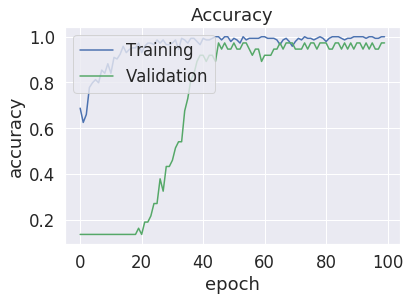

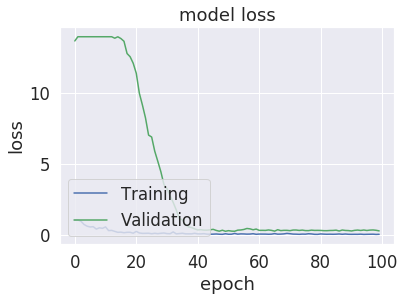

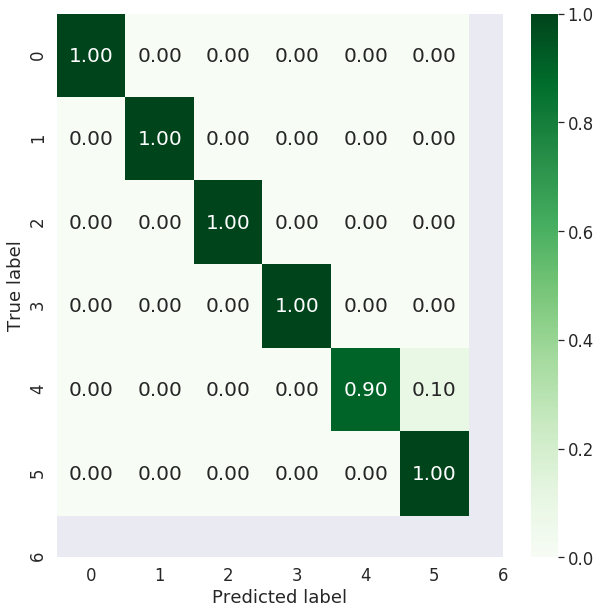

In [32]:
eval_model(cnn_history, cnn_model)

1/1 [==============================] - 0s 14ms/step
Evaluation loss:  0.5280773639678955
Evaluation accuracy:  0.8108108043670654


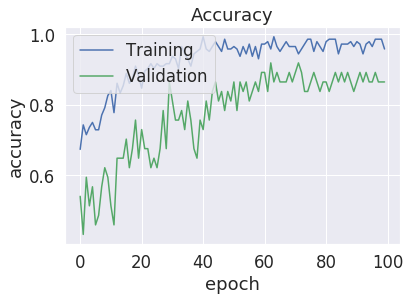

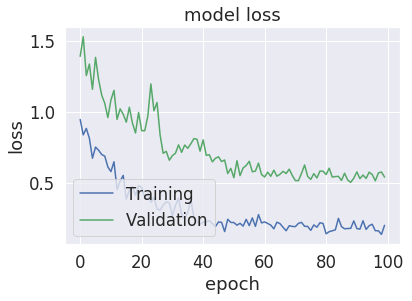

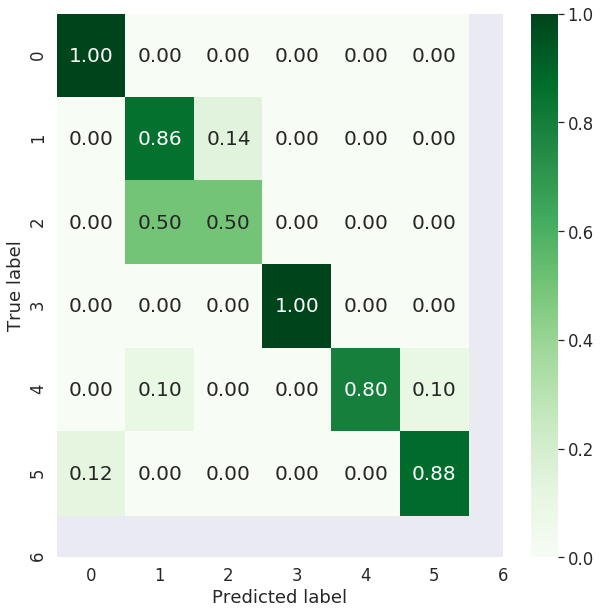

In [33]:
eval_model(nn_history, nn_model)